<a href="https://colab.research.google.com/github/kovidjuneja/BP_Estimator/blob/main/BP_ESTIMATOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries and Functions and Define the Model

In [ ]:
!pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=2cd9154378ba89545aeed31d859571a79fcd99d07e590f7ef047fe7d515c11ac
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [ ]:
from miscFun import *
output_notebook()

In [ ]:
import tensorflow as tf
from keras_self_attention import SeqSelfAttention

def model_DNN_LSTM_with_Conv1D(N_INPUT, N_FEAT=1, N_EXT=100, lstm_units=64, lstm_layers=1):
    inp_beat = tf.keras.Input(shape=(N_INPUT))
    x_expanded = tf.keras.backend.expand_dims(inp_beat, axis=-1)

    # Convolutional layers from emo1d model
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, input_shape=(N_INPUT, 1))(x_expanded)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('elu')(x)

    x = tf.keras.layers.Conv1D(filters=64, kernel_size=3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('elu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=1)(x)

    # Additional Convolutional layers
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('elu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=1)(x)

    # LSTM layers
    lstm_output = tf.keras.layers.LSTM(units=lstm_units, return_sequences=True)(x)
    lstm_output = SeqSelfAttention(attention_activation='tanh')(lstm_output)

    for _ in range(lstm_layers - 1):
        lstm_output = tf.keras.layers.LSTM(units=lstm_units, return_sequences=True)(lstm_output)

    lstm_output = tf.keras.layers.LSTM(units=lstm_units, return_sequences=False)(lstm_output)

    # Fully connected layers
    feat_ext = tf.keras.layers.Flatten()(x)  # Flattening after Conv1D layers
    inp_feat1 = tf.keras.Input(shape=(N_FEAT)) # feat 1
    inp_feat2 = tf.keras.Input(shape=(N_FEAT)) # feat 2
    inp_feat3 = tf.keras.Input(shape=(N_FEAT)) # feat 3
    feat_comb = tf.keras.layers.Concatenate()([inp_feat1, inp_feat2, inp_feat3, lstm_output])
    dense1_1 = tf.keras.layers.Dense(60, activation='relu')(feat_comb)
    out = tf.keras.layers.Dense(N_FEAT)(dense1_1)

    # Model instantiation
    model = tf.keras.Model(inputs=[inp_beat, inp_feat1, inp_feat2, inp_feat3], outputs=[out])
    return model


In [ ]:
def model_DNN(N_INPUT, N_FEAT=1, N_EXT=100):
    # The input to the model is a 1D tensor representing a time series of heartbeat data, sampled with 250/8 points for 30 seconds
    inp_beat=tf.keras.Input(shape=(N_INPUT))

    # Define the 1D CNN for NN feature extraction
    # The input tensor is first expanded by one dimension (from 1D to 2D) to be compatible with the Conv1D layer
    cnn1_1 = tf.keras.layers.Conv1D(32,5,activation='relu')(tf.keras.backend.expand_dims(inp_beat,axis=-1))
    cnn1_2 = tf.keras.layers.Conv1D(64,3,activation='relu')(cnn1_1)
    mp_cnn1 = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1)(cnn1_2)
    fl_cnn1 = tf.keras.layers.Flatten()(mp_cnn1)

    # A fully connected layer further processes the flattened tensor and extracts N_EXT features
    feat_ext = tf.keras.layers.Dense(N_EXT,activation='relu')(fl_cnn1)

    # Define physiological features (case study uses 3 features), each of these features is expected to be a 1D tensor
    inp_feat1 = tf.keras.Input(shape=(N_FEAT)) # feat 1
    inp_feat2 = tf.keras.Input(shape=(N_FEAT)) # feat 2
    inp_feat3 = tf.keras.Input(shape=(N_FEAT)) # feat 3

    # The extracted features and physiological features are concatenated together
    feat_comb = tf.keras.layers.Concatenate()([inp_feat1,inp_feat2,inp_feat3,feat_ext])

    # A fully connected layer with is applied to the concatenated features
    dense1_1 = tf.keras.layers.Dense(60,activation='relu')(feat_comb)
    out = tf.keras.layers.Dense(N_FEAT)(dense1_1)

    # Finally, the model is instantiated with the specified inputs and outputs
    model = tf.keras.Model(inputs=[inp_beat, inp_feat1, inp_feat2, inp_feat3], outputs=[out])
    return model

### Import a Demo Data

In [ ]:
# load an example data for demo
import pandas as pd
df_demo_data = pd.read_pickle('data_demo_pinn_bioz_bp',compression='gzip')

### Preprocess and Prepare the Train/Test Datasets

In [ ]:
# Initialize a SEED value to ensure that the random processes in the code can be reproduced.
SEED = 123

# Call the function with seed value
set_global_determinism(seed=SEED)

# The keys for the beat data (beat_key), the target (out_key), and the features (feat_keys) are defined
beat_key = 'bioz_beats'
out_key = 'sys'
feat_keys = ['phys_feat_1','phys_feat_2','phys_feat_3']

# Data scaling of BP, input beats, and input features
# This scaler standardizes by removing the mean and scaling to unit variance
# This is done to ensure having the same scale, which can improve the performance of machine learning algorithms
scaler_out = preprocessing.StandardScaler().fit(df_demo_data[out_key].to_numpy()[:, None])
scaler_beats = preprocessing.StandardScaler().fit(np.concatenate(df_demo_data[beat_key].to_numpy())[:, None])
scaler_X = [preprocessing.StandardScaler().fit(df_demo_data[a].to_numpy()[:, None]) for a in feat_keys]

# Apply Scaling
# The scaled versions of the BP, input beats, and input features are then added to the dataframe
df_demo_data.loc[df_demo_data.index,beat_key+'_scaled'] = df_demo_data.apply(lambda x: np.concatenate(scaler_beats.transform(x[beat_key][:, None])), axis=1).to_numpy()
df_demo_data.loc[df_demo_data.index,out_key+'_scaled'] = df_demo_data.apply(lambda x: np.concatenate(scaler_out.transform(np.array([x[out_key]])[:, None]))[0], axis=1).to_numpy()
for tmp_key, tmp_count in zip(feat_keys, range(len(feat_keys))):
    df_demo_data.loc[df_demo_data.index, tmp_key+'_scaled'] = df_demo_data.apply(lambda x: np.concatenate(scaler_X[tmp_count].transform(np.array([x[tmp_key]])[:, None])), axis=1).to_numpy()

# Fetch scaled feature names
X_keys = [a+'_scaled' for a in feat_keys]

# Prepare train/test using minimal training the BP
# Fetch data shapes
length_seq_x = df_demo_data.apply(lambda x: len(x[beat_key+'_scaled']), axis=1).unique()[0]
# Set the length of the target to 1
length_seq_y = 1

# Start with all points
# Reshape the scaled beat data into a 2D array where each row corresponds to a sample and each column corresponds to a time point in the beat sequence
# The same is done for the features and the target
all_beats = np.reshape(np.concatenate(df_demo_data[beat_key+'_scaled'].values), (len(df_demo_data), length_seq_x))
[all_feat1, all_feat2, all_feat3] = [df_demo_data[a].values[:, None] for a in X_keys]
all_out = df_demo_data[out_key+'_scaled'].values[:, None]

# Used only for plotting purposes
out_max_rescaled = np.concatenate(scaler_out.inverse_transform(all_out[:, 0][:, None])).max()
out_min_rescaled = np.concatenate(scaler_out.inverse_transform(all_out[:, 0][:, None])).min()

# Given different trials have time gaps, ignore first 3 instances from indices to prevent discontiunity in training
list_all_length = [0]
for _, df_tmp in df_demo_data.groupby(['trial_id']):
    list_all_length.append(len(df_tmp))
ix_ignore_all = np.concatenate(np.array([np.arange(a, a+3,1) for a in list(np.cumsum(list_all_length)[:-1])]))

# Update the final indices set
ix_all=list(set(np.arange(len(df_demo_data)))-set(ix_ignore_all))

# Separate train/test based on minimal training criterion
random.seed(0)
bp_dist = df_demo_data[out_key].values

# Find indices for train and test datasets
# The target values are sorted in ascending order, and the sorted indices are split into multiple subsets
# For each subset, a random index is selected as a training index
ix_split = np.split([a for a in np.argsort(bp_dist) if a not in set(ix_ignore_all)], np.cumsum(np.histogram(bp_dist[ix_all],bins=np.arange(bp_dist[ix_all].min(), bp_dist[ix_all].max(), 1))[0]))
ix_train = [random.Random(4).choice(a) if len(a)>0 else -1 for a in ix_split]
ix_train = list(set(ix_train)-set([-1]))

# Test set is all remaining points not used for training
ix_test = list(set(ix_all) - set(ix_train))

# Build train and test datasets based on the indices
train_beats = all_beats[ix_train, :]
test_beats = all_beats[ix_test, :]
[train_feat1, train_feat2, train_feat3] = [all_feat1[ix_train, :], all_feat2[ix_train, :], all_feat3[ix_train, :]]
[test_feat1, test_feat2, test_feat3] = [all_feat1[ix_test, :], all_feat2[ix_test, :], all_feat3[ix_test, :]]
train_out = all_out[ix_train, :]
test_out = all_out[ix_test, :]


In [ ]:
#### Define model input tensors
# The training, testing, and all data are converted to TensorFlow tensors
# The tensors for the different datasets are grouped into lists

model_inp = tf.convert_to_tensor(train_beats, dtype=tf.float32)
feat1_inp = tf.convert_to_tensor(train_feat1, dtype=tf.float32)
feat2_inp = tf.convert_to_tensor(train_feat2, dtype=tf.float32)
feat3_inp = tf.convert_to_tensor(train_feat3, dtype=tf.float32)
inp_comb = [model_inp, feat1_inp, feat2_inp, feat3_inp]

model_inp_test = tf.convert_to_tensor(test_beats, dtype=tf.float32)
feat1_inp_test = tf.convert_to_tensor(test_feat1, dtype=tf.float32)
feat2_inp_test = tf.convert_to_tensor(test_feat2, dtype=tf.float32)
feat3_inp_test = tf.convert_to_tensor(test_feat3, dtype=tf.float32)
inp_comb_test = [model_inp_test, feat1_inp_test, feat2_inp_test, feat3_inp_test]

model_inp_all = tf.convert_to_tensor(all_beats, dtype=tf.float32)
feat1_inp_all = tf.convert_to_tensor(all_feat1, dtype=tf.float32)
feat2_inp_all = tf.convert_to_tensor(all_feat2, dtype=tf.float32)
feat3_inp_all = tf.convert_to_tensor(all_feat3, dtype=tf.float32)
inp_comb_all = [model_inp_all, feat1_inp_all, feat2_inp_all, feat3_inp_all]

In [ ]:
#############################
###### CNN-LSTM
#############################

# A Deep Neural Network model is initialized with the dimension of the beats, the diemnsion of each feature, and the number of neurons in the first dense layer
model_dnn_conv = model_DNN_LSTM_with_Conv1D(np.shape(train_beats)[-1], 1, 64,64,2)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

# Two lists are initialized to keep track of the training and testing loss during each epoch
loss_list_conv = []
test_loss_list_conv = []

epochs = 5000
for epoch in range(epochs):
    with tf.GradientTape() as tape:

        tape.watch(inp_comb)
        # Traditional out
        yh = model_dnn_conv(inp_comb, training=True)
        loss_ini = yh - train_out
        loss = K.mean(K.square(loss_ini))

    grads = tape.gradient(loss, model_dnn_conv.trainable_weights)

    loss_list_conv.append(float(loss))
    loss_final = np.min(loss_list_conv)
    optimizer.apply_gradients(zip(grads, model_dnn_conv.trainable_weights))

    pred_out = model_dnn_conv(inp_comb_test)

    test_loss_ini = pred_out - test_out
    test_loss = K.mean(K.square(test_loss_ini))
    test_loss_list_conv.append(float(test_loss))

    # If the training loss reaches a minimum value of 0.01, or the maximum number of epochs is reached, the training process is stopped
    if (loss_final<=0.000001) | (epoch==epochs-1):
        print("CNN LSTM model training Completed. Epoch %d/%d -- loss: %.8f" % (epoch, epochs, float(loss)))
        break

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


CNN LSTM model training Completed. Epoch 645/5000 -- loss: 0.00000096


### Train the PINN model

In [ ]:
#############################
############### PINN MODEL
#############################

# A Deep Neural Network model is initialized with the dimension of the beats, the diemnsion of each feature, and the number of neurons in the first dense layer
model_dnn_pinn = model_DNN(np.shape(train_beats)[-1], 1, 64)
optimizer = tf.keras.optimizers.Adam(learning_rate=10e-4)

# Two lists are initialized to keep track of the training and testing loss during each epoch
loss_list_pinn = []
test_loss_list_pinn = []

epochs = 5000
for epoch in range(epochs):
    with tf.GradientTape() as tape:

        tape.watch(inp_comb)
        # Traditional out
        yh = model_dnn_pinn(inp_comb, training=True)
        loss_ini = yh - train_out
        loss = K.mean(K.square(loss_ini))

        # Additional tf.GradientTape contexts are used to compute the derivatives of the model's predictions with respect to the features
        with tf.GradientTape() as deriv_f1:
            deriv_f1.watch(inp_comb_all)
            yhp = model_dnn_pinn(inp_comb_all, training=True)
        dx_f1 = deriv_f1.gradient(yhp, feat1_inp_all)

        with tf.GradientTape() as deriv_f2:
            deriv_f2.watch(inp_comb_all)
            yhp = model_dnn_pinn(inp_comb_all, training=True)
        dx_f2 = deriv_f2.gradient(yhp, feat2_inp_all)

        with tf.GradientTape() as deriv_f3:
            deriv_f3.watch(inp_comb_all)
            yhp = model_dnn_pinn(inp_comb_all, training=True)
        dx_f3 = deriv_f3.gradient(yhp, feat3_inp_all)

        # A physics-based prediction is computed by adding the model's predictions to the product of the computed derivatives and
        # the differences in the feature values between consecutive timesteps
        pred_physics = (yhp[:-1, 0]
                        +Multiply()([dx_f1[:-1, 0], feat1_inp_all[1:, 0] - feat1_inp_all[:-1, 0]])
                        +Multiply()([dx_f2[:-1, 0], feat2_inp_all[1:, 0] - feat2_inp_all[:-1, 0]])
                        +Multiply()([dx_f3[:-1, 0], feat3_inp_all[1:, 0] - feat3_inp_all[:-1, 0]])
                        )

        physics_loss_ini = pred_physics - yhp[1:, 0]
        physics_loss = K.mean(K.square(tf.gather_nd(physics_loss_ini,indices = np.array(ix_all[:-1])[:, None])))

        # The total loss is computed as the sum of the initial loss and ten times the physics-based loss
        # The physics-based loss is multiplied by a factor of ten to emphasize its importance in the loss function
        loss_total = loss + physics_loss * 10

    grads = tape.gradient(loss_total, model_dnn_pinn.trainable_weights)

    loss_list_pinn.append(float(loss))
    loss_final=np.min(loss_list_pinn)
    optimizer.apply_gradients(zip(grads, model_dnn_pinn.trainable_weights))

    pred_out = model_dnn_pinn(inp_comb_test)
    test_loss_ini = pred_out - test_out
    test_loss = K.mean(K.square(test_loss_ini))
    test_loss_list_pinn.append(float(test_loss))

    # If the training loss reaches a minimum value of 0.01, or the maximum number of epochs is reached, the training process is stopped
    if (loss_final<=0.01) | (epoch==epochs-1):
        print("PINN model training Completed. Epoch %d/%d -- loss: %.4f" % (epoch,epochs,float(loss)))
        break

PINN model training Completed. Epoch 4974/5000 -- loss: 0.0099


In [ ]:
#The trained model's predictions on the test dataset are computed
pred_out = model_dnn_conv(inp_comb_test)

#The Pearson correlation coefficient and the Root Mean Square Error are calculated between the actual and predicted test outcomes
corr_conv = np.corrcoef(np.concatenate(test_out)[:], np.concatenate(pred_out)[:])[0][1]
rmse_conv = np.sqrt(np.mean(np.square
                           (np.concatenate(scaler_out.inverse_transform(np.concatenate(test_out)[:][:, None]))-
                            np.concatenate(scaler_out.inverse_transform(np.concatenate(pred_out)[:][:, None])))))

pred_out = model_dnn_pinn(inp_comb_test)
corr_pinn = np.corrcoef(np.concatenate(test_out)[:], np.concatenate(pred_out)[:])[0][1]
rmse_pinn = np.sqrt(np.mean(np.square(
    np.concatenate(scaler_out.inverse_transform(np.concatenate(test_out)[:][:, None]))-
    np.concatenate(scaler_out.inverse_transform(np.concatenate(pred_out)[:][:, None])))))

print('#### CNN-LSTM Performance ####')
print('Corr: %.2f,  RMSE: %.1f'%(corr_conv, rmse_conv))
print('----------------------------------')
print('#### PINN Performance ####')
print('Corr: %.2f,  RMSE: %.1f'%(corr_pinn, rmse_pinn))

#### CNN-LSTM Performance ####
Corr: 0.89,  RMSE: 8.9
----------------------------------
#### PINN Performance ####
Corr: 0.95,  RMSE: 5.3


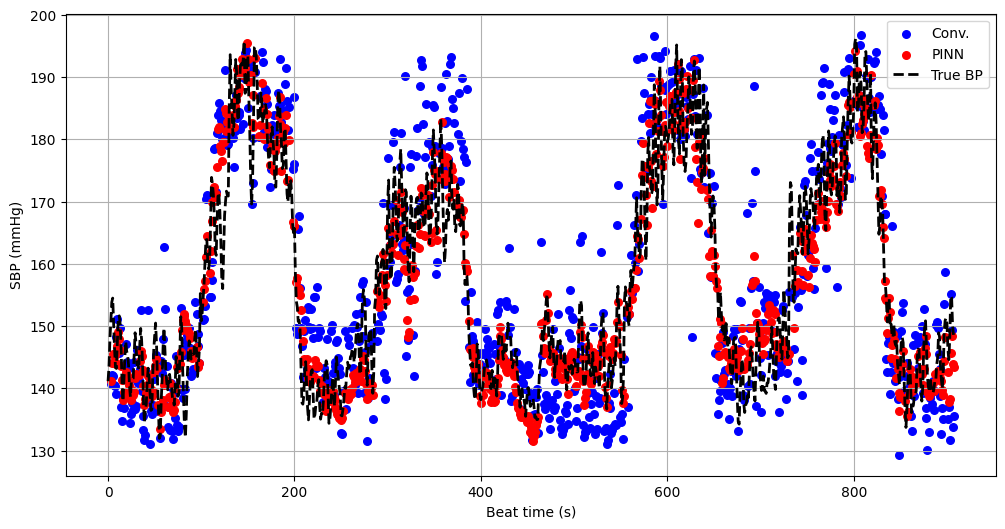

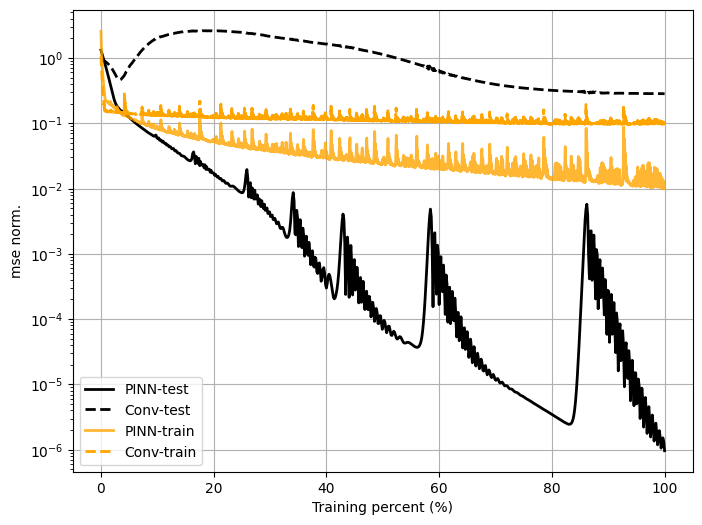

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting scatter and line plots
plt.figure(figsize=(12, 6))

plt.scatter(ix_test, np.concatenate(scaler_out.inverse_transform(np.concatenate(model_dnn_conv(inp_comb_test))[:, None])), s=30, color='blue', label='Conv.')
plt.scatter(ix_test, np.concatenate(scaler_out.inverse_transform(np.concatenate(model_dnn_pinn(inp_comb_test))[:, None])), s=30, color='red', label='PINN')
plt.plot(range(len(df_demo_data)), np.concatenate(scaler_out.inverse_transform(all_out[:, 0][:, None])), linewidth=2, linestyle='--', color='black', label='True BP')

plt.xlabel('Beat time (s)')
plt.ylabel('SBP (mmHg)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting line plots with log scale
plt.figure(figsize=(8, 6))

plt.plot(np.linspace(0, 100, len(loss_list_conv)), loss_list_conv, linewidth=2, linestyle='-', color='black', label='PINN-test')
plt.plot(np.linspace(0, 100, len(test_loss_list_conv)), test_loss_list_conv, linewidth=2, linestyle='--', color='black', label='Conv-test')
plt.plot(np.linspace(0, 100, len(loss_list_pinn)), loss_list_pinn, linewidth=2, linestyle='-', alpha=0.8, color='orange', label='PINN-train')
plt.plot(np.linspace(0, 100, len(test_loss_list_pinn)), test_loss_list_pinn, linewidth=2, linestyle='--', color='orange', label='Conv-train')

plt.yscale('log')
plt.xlabel('Training percent (%)')
plt.ylabel('mse norm.')
plt.legend()
plt.grid(True)
plt.show()
